<h1><center> Binary classification as a phase separation process</center></h1>
<center>Rafael Monteiro <br>Mathematics for advanced Materials - Open Innovation Lab (MathAM-OIL, AIST), Sendai, Japan<br>
email : monteirodasilva-rafael@aist.jp, rafael.a.monteiro.math@gmail.com
</center>

This is a companion website to the article **Binary classification as a phase separation process**,
by [Rafael Monteiro](https://sites.google.com/view/rafaelmonteiro-math/home). A preprint is available on arXiv  https://arxiv.org/abs/2009.02467.

For the dataset and trainable models, see the <a href="https://doi.org/10.5281/zenodo.4005131"> data repository</a> at Zenodo.

In [1]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import  matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
import scipy.sparse as sc
import sympy
import itertools as it

###-----------------------------------
## The modules for this paper are here
from  binary_phase_separation import *
from aux_fnts_for_jupyter_notebooks import *
###-----------------------------------

### In order to open ans save dictionaries
try:
    import cPickle as pickle
except ImportError: # python 3.x
    import pickle

import pandas as pd
import warnings
warnings.filterwarnings(action = "ignore", message = "internal issue")

## Things necessary to do nice plots
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from  matplotlib.transforms import Affine2D

# where we are saving stuff
import os, glob
PROJECT_DIR =  os.getcwd()
IMAGES = os.path.join(PROJECT_DIR,"figures/")
PROJECT_DIR = os.path.join(PROJECT_DIR)

In [2]:
from matplotlib import rcParams
plt.rc('axes',labelsize = 18)
plt.rc('xtick',labelsize = 16)
plt.rc('ytick',labelsize = 16)
plt.rc('font', size = 20)
plt.rc('legend',fontsize = 18)
rcParams['font.family'] =  "Times New Roman"
rcParams['mathtext.fontset'] = 'custom' 
rcParams['lines.linewidth'] = 2
rcParams['lines.markersize'] = 10
rcParams['lines.markeredgewidth'] = 3

In [3]:
subfolders, parameters = {}, {}
stats_folder_1D = "Statistics/1D/"

with open(stats_folder_1D + "parameters_1D.p", 'rb') as fp: parameters = pickle.load(fp)

In [4]:
parameters.keys()

dict_keys(['W1S-NP', 'WNtS-NP', 'WNtS-NP_BC', 'WNtS-WP_BC', 'WkS-WP_vary'])

<h1 align="center">1D models </h1>


In [5]:
N = 1
init = Initialize_parameters()
prop = Propagate()
dt_vec = np.array([.1,.3,.57,1.5,3,4])
dt, eps, Nx, Nt, dx = .1, 0, N, 20, 1
ptt_cardnlty = Nx
weights_k_sharing = Nt

In [6]:
param = init.dictionary(N, eps, dt, dx, Nt, ptt_cardnlty, weights_k_sharing)
for i in range(param["Nt"]):
    param["alpha_x_t"][:,i] = np.random.uniform(0,1)

n_points = 10    
V_0 = np.reshape(1/n_points * np.arange(0, n_points + 1), (1,-1))
flow, waterfall, time = prop.forward(V_0, param, waterfall_save = True , Flow_save = True)

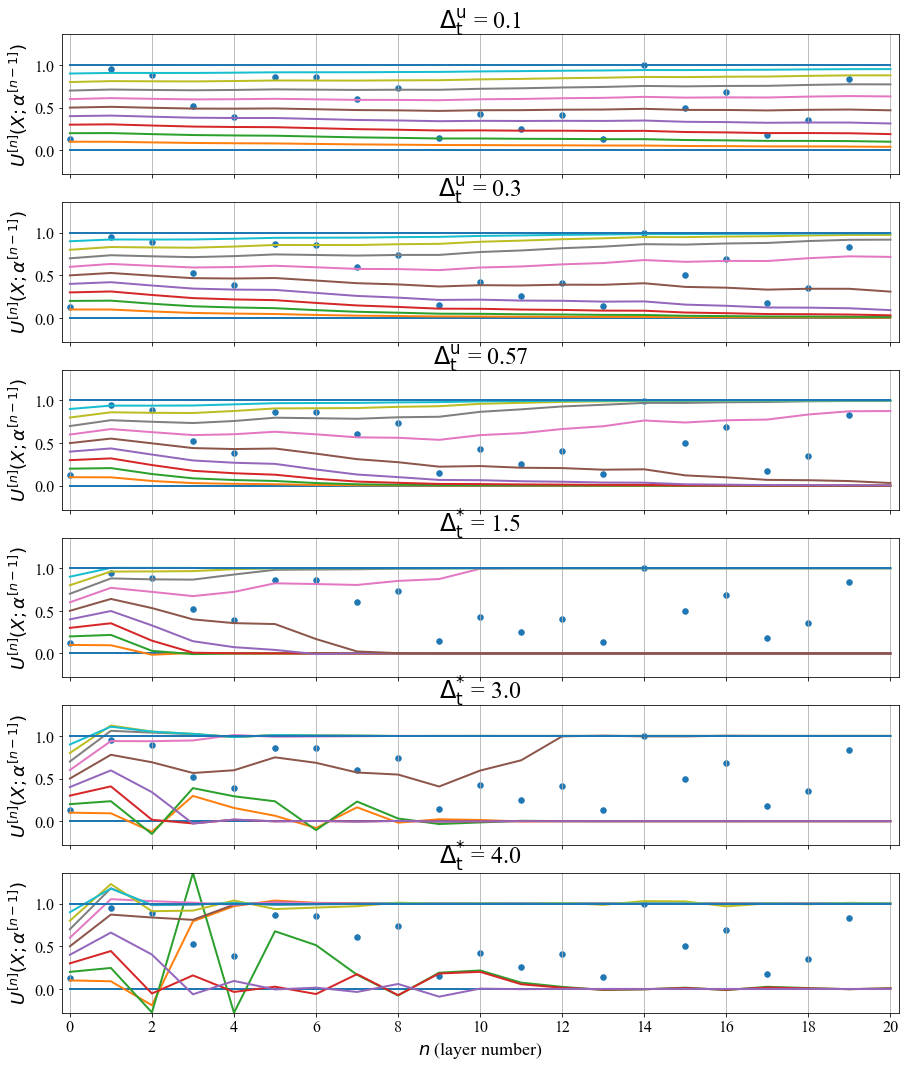

In [7]:
# To reproduce the graph in paper, set np.random.seed(123)

np.random.seed(67023423)
A = np.reshape(np.random.uniform(0,1, size = Nt), (1,-1))
x_ticks = np.arange(0,21,2)
n_points = 10    
V_0 = np.reshape(1/n_points*np.arange(0,n_points + 1), (1,-1))

fig, ax = plt.subplots(ncols = 1,nrows = 6, figsize = (15,18), sharex = True,\
                       gridspec_kw = {'wspace': .42})
m, M = 0,1

for i in range(6):
    dt = dt_vec[i]
    param = init.dictionary(N, eps, dt, dx, Nt, ptt_cardnlty, weights_k_sharing)
    param["alpha_x_t"] = A

    flow, waterfall, time = prop.forward(V_0, param, waterfall_save = True , Flow_save = True)
    
    m, M = min(m, np.min(flow)), max(M, np.max(flow))
    if i <3: ax[i].set_title(r"$\Delta_{\mathrm{t}}^{\mathrm{u}}$ = " + str(dt))
    else: ax[i].set_title(r"$\Delta_{\mathrm{t}}^{\mathrm{*}}$ = " + str(dt))
    ax[i].set_xlim([-.2,20.2])
    
    ax[i].set_ylabel(r"$U^{[n]}(X;\alpha^{[n-1]})$")
    ax[i].set_xticks(x_ticks)
    
    if i == 5:
        ax[i].set_xlabel(r"$n$ (layer number)")
    ax[i].scatter(np.arange(0,param["alpha_x_t"].shape[1]),\
                  param["alpha_x_t"].T, marker = 'o', s = 30)
    ax[i].plot(flow[0,:].T)
    ax[i].grid(True, axis = 'x')
    
## Adjust height
for i in range(6):
    ax[i].set_ylim([m,M])

plt.show()

<h2 align="left"> A) PSBC with 1 feature: weights-1-sharing, no phase </h2>

We shall start with a simple case with labels
$$ Y_{(i)} = 1_{\{x> \alpha\}}(X_{(i)})$$

where $\alpha \in \{0.6, 0.7, 0.8\}$. This corresponds to label 2.9 in the paper.

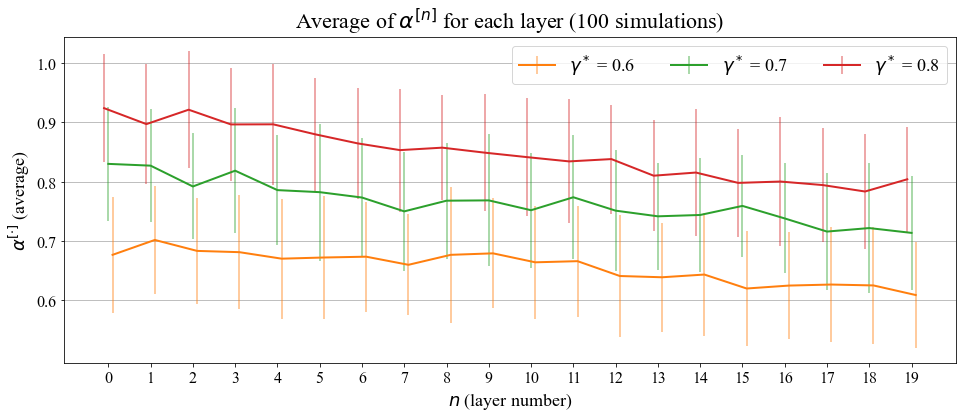

In [8]:
from  matplotlib.transforms import Affine2D

y_ticks_vec= .1*np.arange(6,11)
y_ticks_vec = np.round(y_ticks_vec,1)
fig, ax  = plt.subplots(figsize = (16,6))
colors = pl.cm.tab20(np.linspace(0,1,10))
colors_markers = pl.cm.Dark2(np.linspace(0,1,6))

for alpha in [6,7,8]:
    trans_now = Affine2D().translate(.1 * (7-alpha),0) + ax.transData
    data_now = parameters["W1S-NP"]["gamma" + str(alpha)]
    average = np.mean(data_now["alpha_all"], axis = 0)
    stdev = np.std(data_now["alpha_all"], axis = 0)
    markers, caps, bars = ax.errorbar(
        np.arange(len(average)),average, yerr = stdev, errorevery = 1,\
        transform = trans_now, color = colors[alpha-5],\
         label = r"$\gamma^*$ = 0." + str(alpha)
    )
    [bar.set_alpha(0.4) for bar in bars]

ax.grid(axis = 'y')
ax.set_ylabel(r'$\alpha^{[\cdot]}$ (average)')
ax.set_xlabel(r'$n$ (layer number)')
ax.legend(loc = 3)
ax.set_xticks(np.arange(parameters["W1S-NP"]["gamma6"]["data"]["Nt"]))
ax.set_xticklabels(np.arange(parameters["W1S-NP"]["gamma6"]["data"]["Nt"]))
ax.set_yticks(y_ticks_vec,)
ax.set_yticklabels(y_ticks_vec)
ax.set_ylim=[-.1 + min(y_ticks_vec), max(y_ticks_vec) - .1]
ax.set_title(r"Average of $\alpha^{[n]}$ for each layer (100 simulations)",fontsize=22)
plt.legend(ncol = 3)
plt.show()

It is also interesting to see how the layers vary in the Weights-1-sharing case

In [9]:
M = np.zeros([20,600])
for i in range(600):
    M[:,i] = np.squeeze(parameters["W1S-NP"]["gamma6"]["par_U_hist"][str(i)]["alpha_x_t"])
    
M = M[::-1,:]    

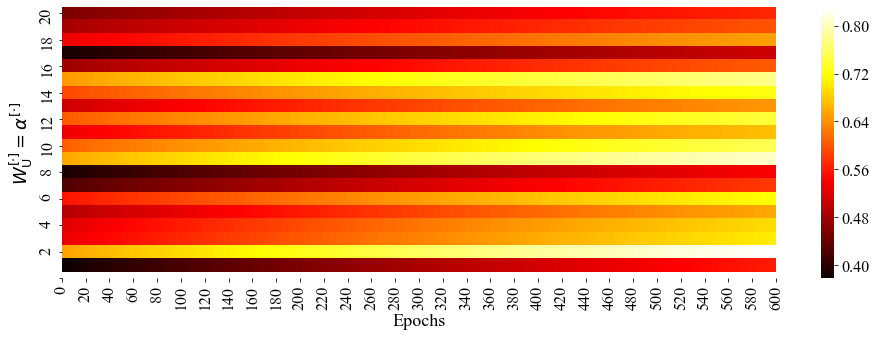

In [10]:
import seaborn as sns
%matplotlib inline

plt.figure(figsize = (16,5))
ax = sns.heatmap(M, cmap = plt.cm.hot)
ax.set_xticks( np.arange(0,601,20) )
ax.set_xticklabels( np.arange(0,601,20) )
ax.set_yticks(.5+ np.arange(0,21,2) )
ax.set_yticklabels( np.arange(2,21,2)[::-1] )
ax.set_ylabel(r'$W_{\mathrm{U}}^{[\cdot]} = \alpha^{[\cdot]}$')
ax.set_xlabel("Epochs")
plt.show()

We can plot the evolution of accuracies as the model gets applied to training and test set.

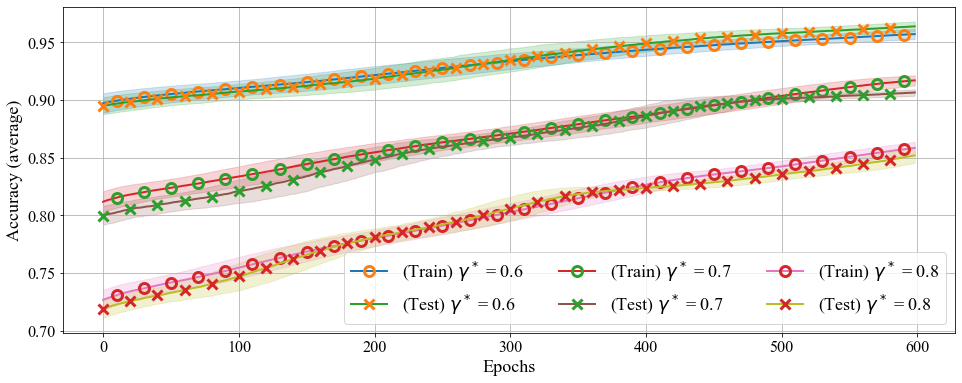

In [11]:
x_ticks_vec = np.arange(0,parameters["W1S-NP"]["gamma6"]["data"]["epochs"] + 1, 50)
plt.figure(figsize = (16,6))

plt.setp(
    ax, xticks = x_ticks_vec,\
    xticklabels = x_ticks_vec
)

alpha_for_all = 0.2
colors = pl.cm.tab10(np.linspace(0,1,10))
colors_markers = pl.cm.tab10(np.linspace(0,1,10))
alphas =[6,7,8]

for i in range(6,9):
    A = parameters["W1S-NP"]["gamma" + str(i)]["accuracy_test"]
    Tr = parameters["W1S-NP"]["gamma" + str(i)]["accuracy_train"]
    
    average_train = np.mean(Tr, axis = 0)
    stdev_train = np.std(Tr, axis = 0)
    average_test = np.mean(A, axis = 0)
    stdev_test = np.std(A, axis = 0)
    
    plt.plot(
        np.arange(len(average_train)),average_train, c=colors[3 * (i - 6)],\
        label = r"(Train) $\gamma^*$ = 0." + str(alphas[i - 6]),\
        fillstyle = 'none', markevery =(10,20), marker = 'o',\
        markeredgecolor =  colors_markers[(i - 6) + 1], markerfacecolor = None
    )
    plt.fill_between(
        np.arange(len(average_train)),average_train - stdev_train,average_train + stdev_train,\
        color = colors[3*(i - 6)], alpha = alpha_for_all
    )
    plt.plot(
        np.arange(len(average_test)),average_test, c=colors[3 * (i - 6) + 2],\
        label = r"(Test) $\gamma^*$ = 0." + str(alphas[i - 6]),\
        fillstyle = 'none', markevery =20, marker = 'x',\
        markeredgecolor =  colors_markers[(i - 6) + 1], markerfacecolor = None
    )
    plt.fill_between(
        np.arange(len(average_test)),average_test - stdev_test,average_test + stdev_test,\
        color = colors[3*(i - 6)+2], alpha = alpha_for_all
    )

    plt.ylabel('Accuracy (average)')
    plt.grid(True)
    plt.legend(loc = 4)
    plt.xlabel('Epochs') 

plt.legend(loc = 4, ncol = 3)
plt.show()

Let's obtain the model accuracies, with the values held by the model as of its last epoch (this corresponds to table 1a in the paper).

In [12]:
import pandas as pd

M = []
for alpha in [6,7,8]:
    data_now = parameters["W1S-NP"]["gamma" + str(alpha)].copy()
    av_test_now = np.mean(data_now["accuracy_test"])
    std_test_now = np.std(data_now["accuracy_test"])
    av_train_now = np.mean(data_now["accuracy_train"])
    std_train_now = np.std(data_now["accuracy_train"])
    
    M.append(
        (("0." + str(alpha)),(str(np.round(av_train_now,3))) +\
         " + " + str(np.round(std_train_now,3)),\
         (str(np.round(av_test_now,3)) + " + " + str(np.round(std_test_now,3)))
    ))   

f = pd.DataFrame(M, columns = [r"$\alpha$","training set", "test set"])
f.style.hide_index()

$\alpha$,training set,test set
0.6,0.931 + 0.019,0.933 + 0.023
0.7,0.869 + 0.031,0.863 + 0.034
0.8,0.8 + 0.039,0.796 + 0.039


The model accuracies at their best epochs are given below (this table is given in the supplement).

In [13]:
import pandas as pd

M = []
for alpha in [6,7,8]:
    data_now = parameters["W1S-NP"]["gamma" + str(alpha)].copy()

    av_test_now = np.mean(data_now["best_accuracy_test"])
    std_test_now = np.std(data_now["best_accuracy_test"])
    av_train_now = np.mean(data_now["best_accuracy_train"])
    std_train_now = np.std(data_now["best_accuracy_train"])
    
    M.append(
        (("0." + str(alpha)),(str(np.round(av_train_now,3))) +\
         " + " + str(np.round(std_train_now,3)),\
        (str(np.round(av_test_now,3)) + " + " + str(np.round(std_test_now,3)))
    ))   

f = pd.DataFrame(M, columns = [r"$\alpha$","training set", "test set"])
f.style.hide_index()

$\alpha$,training set,test set
0.6,0.957 + 0.004,0.963 + 0.004
0.7,0.917 + 0.004,0.906 + 0.003
0.8,0.859 + 0.005,0.851 + 0.007


<h2 align="left"> B) PSBC with 1 feature: weights-Nt-sharing, no phase </h2>

For th enext part, look at [matplotlib.pyplot.axes](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.axes.html), [axes_demo](https://matplotlib.org/examples/pylab_examples/axes_demo.html), [mpl_toolkits/axes_grid](https://matplotlib.org/1.3.1/mpl_toolkits/axes_grid/users/overview.html), [how-to-zoomed-a-portion-of-image-and-insert-in-the-same-plot-in-matplotlib](https://stackoverflow.com/questions/13583153/how-to-zoomed-a-portion-of-image-and-insert-in-the-same-plot-in-matplotlib), and [matplotlib-zoomed-up-inset](http://akuederle.com/matplotlib-zoomed-up-inset).

/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


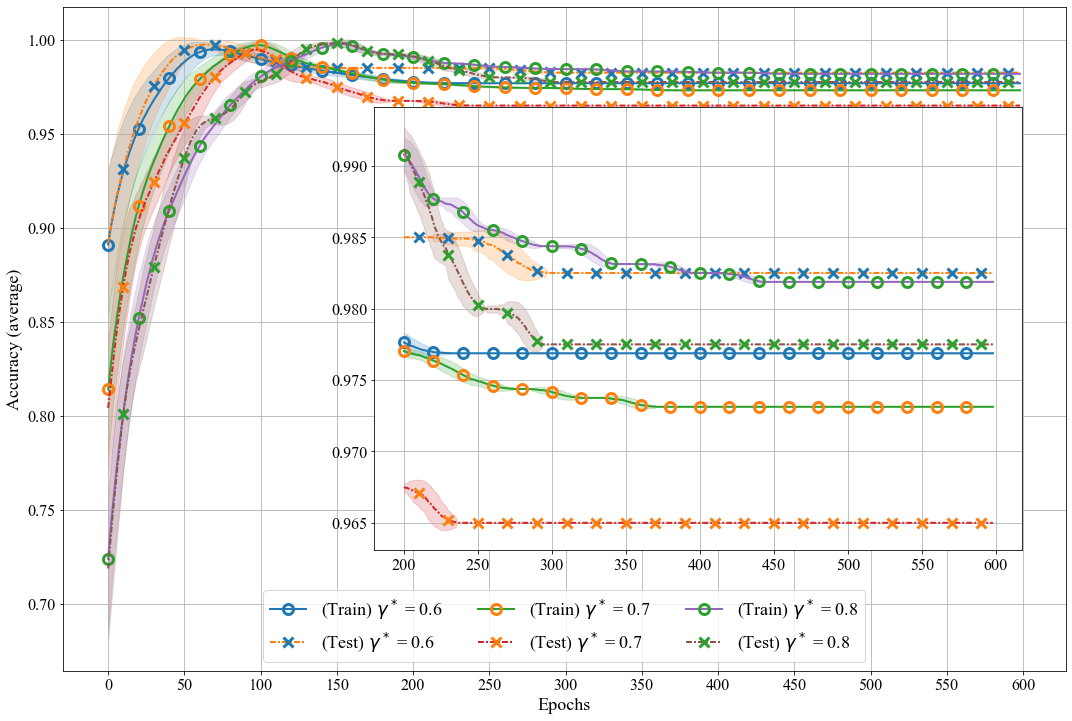

In [14]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax = plt.subplots(figsize = (15,11)) 
x_ticks_vec = np.arange(0,parameters["WNtS-NP"]["gamma6"]["data"]["epochs"] + 1, 50)

plt.setp(
    ax, xticks = x_ticks_vec,\
    xticklabels = x_ticks_vec
)

colors = pl.cm.tab10(np.linspace(0,1,10))
colors_markers = pl.cm.tab10(np.linspace(0,1,10))

## Some plotting parameters
L, alpha_for_all = None, .2
alphas = [6,7,8]

for i in range(6,9):
    A = parameters["WNtS-NP"]["gamma" + str(i)]["accuracy_test"]
    Tr = parameters["WNtS-NP"]["gamma" + str(i)]["accuracy_train"]
    
    average_train = np.mean(Tr, axis = 0)
    stdev_train = np.std(Tr, axis = 0)
    average_test = np.mean(A, axis = 0)
    stdev_test = np.std(A, axis = 0)

    ax.plot(
        np.arange(len(average_train))[L:],average_train[L:],\
        linestyle = '-',
        label = r"(Train) $\gamma^*$ = 0." + str(alphas[i - 6]),\
        marker = "o", markevery = 20,\
        fillstyle = 'none', c = colors[2 * (i - 6)],\
        markeredgecolor = colors_markers[(i - 6)], markerfacecolor = None
    )
    ax.fill_between(
        np.arange(len(average_test))[L:],(average_train - stdev_train)[L:],\
        (average_train + stdev_train)[L:],\
        alpha = alpha_for_all,\
        color = colors[2 * (i - 6)]
    )
    ax.plot(
        np.arange(len(average_test))[L:],average_test[L:],\
        linestyle = (0,(3,1,1,1)),
        label = r"(Test) $\gamma^*$ = 0." + str(alphas[i - 6]), marker = "x", markevery = (10,20),\
        fillstyle = 'none', c = colors[2 * (i - 6) + 1], markeredgecolor = colors_markers[(i - 6)],\
        markerfacecolor = None
    )
    ax.fill_between(
        np.arange(len(average_test))[L:], (average_test - stdev_test)[L:],\
        (average_test + stdev_test)[L:], alpha = alpha_for_all,\
        color = colors[2 * (i - 6) + 1]
    )

ax.set_ylabel('Accuracy (average)')
ax.grid(True)
ax.legend(loc = 4)
ax.set_xlabel('Epochs') 
    
###########################
### Small subfigure
axins = plt.axes([0.35, 0.25, 0.6, 0.56])
L= 200#None

alphas = [6,7,8]
for i in range(6,9):
    A = parameters["WNtS-NP"]["gamma" + str(i)]["accuracy_test"]
    Tr = parameters["WNtS-NP"]["gamma" + str(i)]["accuracy_train"]
    
    average_train = np.mean(Tr, axis = 0)
    stdev_train = np.std(Tr, axis = 0)
    average_test = np.mean(A, axis = 0)
    stdev_test = np.std(A, axis = 0)

    axins.plot(
        np.arange(len(average_train))[L:],average_train[L:],\
        linestyle = '-',
        label = None, marker = "o", markevery = 20,\
        fillstyle = 'none', c = colors[2 * (i - 6)],\
        markeredgecolor = colors_markers[(i - 6)], markerfacecolor = None
    )
    axins.fill_between(
        np.arange(len(average_test))[L:], (average_train - stdev_train)[L:],\
        (average_train + stdev_train)[L:],\
        alpha = alpha_for_all,\
        color = colors[2 * (i - 6)]
    )
    axins.plot(
        np.arange(len(average_test))[L:],average_test[L:],\
        linestyle = (0,(3,1,1,1)),
        label = None, marker = "x", markevery = (10,20), \
        fillstyle = 'none', c = colors[2 * (i - 6) + 1],\
        markeredgecolor = colors_markers[(i - 6)], markerfacecolor = None
    )
    axins.fill_between(
        np.arange(len(average_test))[L:], (average_test - stdev_test)[L:],\
        (average_test + stdev_test)[L:], alpha = alpha_for_all, color = colors[2 * (i - 6) + 1]
    )

axins.grid(True)
plt.tight_layout(rect = [0, 0.03, 1, 0.95]) 
ax.legend(ncol = 3,loc = 8)
plt.show()

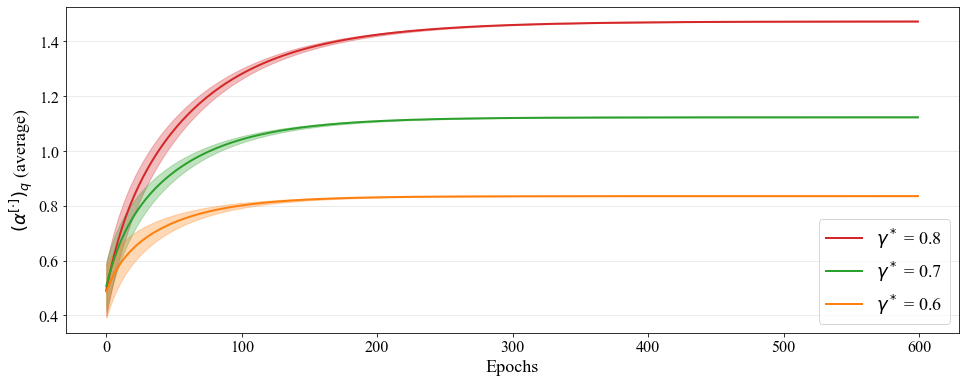

In [15]:
plt.figure(figsize = (16,6))

plt.setp(
    ax, xticks = np.arange(0,parameters["WNtS-NP"]["gamma6"]["data"]["epochs"] + 1,50),\
    xticklabels = np.arange(0,parameters["WNtS-NP"]["gamma6"]["data"]["epochs"] + 1,50),\
    yticks = [.4,  .6,.8,1,1.2,1.4,1.6],
    yticklabels = [.4,  .6,.8,1,1.2,1.4,1.6], ylim = [.3,1.7]
)

alpha_for_all = .3
for alpha in [8, 7, 6]:
    data_now = parameters["WNtS-NP"]["gamma" + str(alpha)]
    A = data_now["alpha_all"]
    average = np.mean(A, axis = 0)
    stdev = np.std(A, axis = 0)

    plt.plot(
        np.arange(len(average)), average, color = "C" + str(alpha-5),\
         label = r"$\gamma^*$ = 0." + str(alpha)
    )
    plt.fill_between(
        np.arange(len(average)), average - stdev,average + stdev,\
        color = "C" + str(alpha-5), alpha = alpha_for_all
    )
    plt.grid(axis ='y',alpha=.3)
    plt.ylabel(r'$(\alpha^{[\cdot]})_q$ (average)')
    plt.xlabel('Epochs')
    plt.legend(loc = 4)
    
plt.show()

Tables 1b and that given in the supplement can be generated in a similar was as the tables given above.

At discussed in the paper, it seems a bit strange that the model already starts with 90% accuracy. Is this a matter of lucky? No. It has to do with the initialization: from the very beginning the algorithms already sends the elements above .6 to the right label, and the elements below .5 to 0. Hence, about 90% of the cases are from the beginnin correct. 

We should not be that surprised then. 

<h1 align="left"> C) PSBC with 1 feature: weights-Nt-sharing, no phase (Label 2.12) </h1>

If we do not add  the phase, the model does not go well. For instance, considering the case of 

$$ Y_{(i)} = 1_{\{x\leq \alpha\}}(X_{(i)})$$

for $\alpha = 0.6.$

Let's take a look at the accuracies

In [16]:
M = []
for alpha in [6,7,8]:
    data_now = parameters["WNtS-NP_BC"]["gamma" + str(alpha)].copy()
    av_test_now = np.mean(data_now["accuracy_test"])
    std_test_now = np.std(data_now["accuracy_test"])
    av_train_now = np.mean(data_now["accuracy_train"])
    std_train_now = np.std(data_now["accuracy_train"])
    
    M.append(
        (("0." + str(alpha)),(str(np.round(av_train_now,3))) + " + " + str(np.round(std_train_now,3)),
        (str(np.round(av_test_now,3)) + " + " + str(np.round(std_test_now,3)))
    ))   

f = pd.DataFrame(M, columns = [r"$\alpha$","training set", "test set"])
f.style.hide_index()

$\alpha$,training set,test set
0.6,0.515 + 0.109,0.49 + 0.12
0.7,0.618 + 0.093,0.607 + 0.103
0.8,0.705 + 0.086,0.69 + 0.097


And even at the best epoch, things don't get much better

In [17]:
M = []
for alpha in [6,7,8]:
    data_now = parameters["WNtS-NP_BC"]["gamma" + str(alpha)].copy()
    av_test_now = np.mean(data_now["best_accuracy_test"])
    std_test_now = np.std(data_now["best_accuracy_test"])
    av_train_now = np.mean(data_now["best_accuracy_train"])
    std_train_now = np.std(data_now["best_accuracy_train"])
    
    M.append(
        (("0." + str(alpha)),(str(np.round(av_train_now,3))) +\
         " + " + str(np.round(std_train_now,3)),\
         (str(np.round(av_test_now,3)) + " + " + str(np.round(std_test_now,3)))
    ))   

f = pd.DataFrame(M, columns = [r"$\alpha$","training set", "test set"])
f.style.hide_index()

$\alpha$,training set,test set
0.6,0.577 + 0.0,0.562 + 0.0
0.7,0.668 + 0.0,0.665 + 0.0
0.8,0.75 + 0.0,0.743 + 0.0


What is going on here?

This part has been discussed at lehgth in the paper, so I'll try to be brief. What happens is that, in this way, the model is label dependent since there's no way it can have lower values of u(0) satisfying $\lim_{t\to+\infty}u(t) =1$, while high values of u(0) satisfying $\lim_{t\to+\infty}u(t) =0$; this is due to the theorem of existence and uniqueness in ODE theory.

There is away to fix that though: we add another equation, that will behave as a phase: it essentialy  captures this type of phenomena and switch the labels. To be more precise, the labels remain the same, but the phase term correctly fix the limits.

Luckily, the phase equation is the same as the previous one. However, its term w_phase is trained separately:


We can solve it introducing a phase term

Before we move on, let's plot the previous case again the bad results we had gotten before:

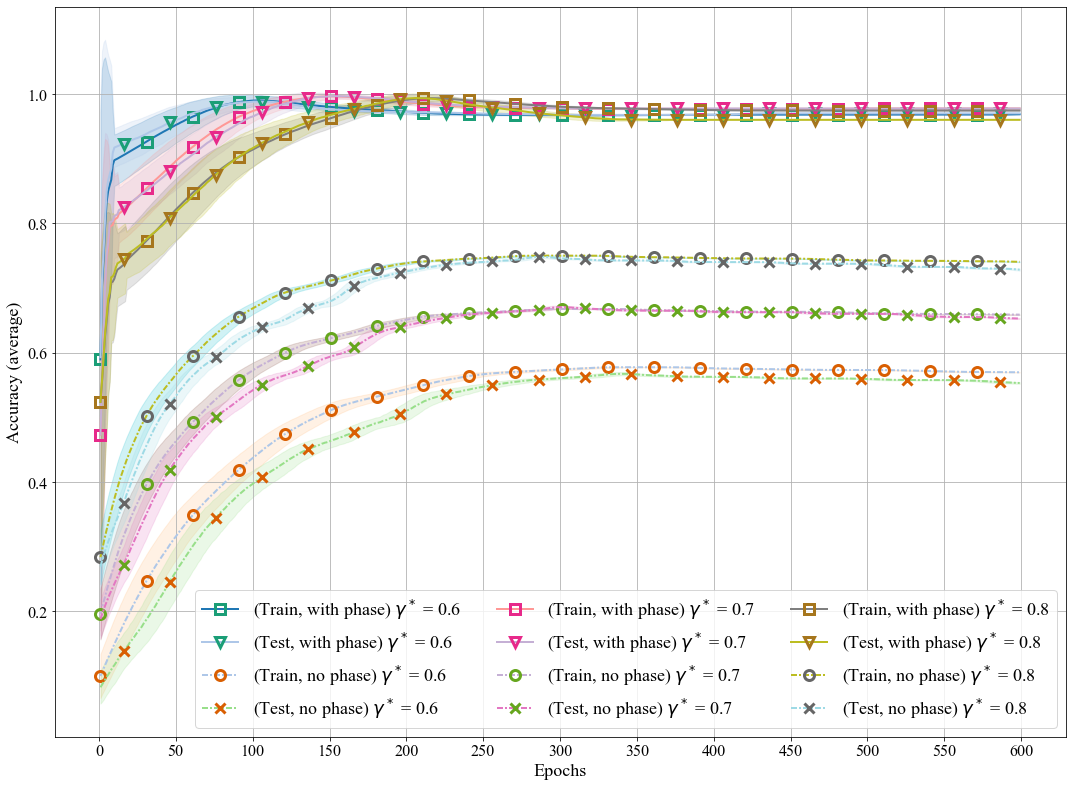

In [18]:
x_ticks_vec = np.arange(0,parameters["WNtS-WP_BC"]["gamma6"]["data"]["epochs"] + 1, 50)
fig = plt.figure(figsize = (15,12))
gs = gridspec.GridSpec(1, 1)
ax = [fig.add_subplot(ss) for ss in gs]

alpha_for_all = 0.2
plt.setp(
    ax, xticks = x_ticks_vec,\
    xticklabels = x_ticks_vec,\
)

colors = pl.cm.tab20(np.linspace(0,1,12))
colors_markers = pl.cm.Dark2(np.linspace(0,1,6))

M_every = 30
alphas = [6,7,8]

for i in range(6,9):
    A_good = parameters["WNtS-WP_BC"]["gamma" + str(i)]["accuracy_test"]
    Tr_good = parameters["WNtS-WP_BC"]["gamma" + str(i)]["accuracy_train"]
    
    average_train_good = np.mean(Tr_good, axis = 0)
    stdev_train_good = np.std(Tr_good, axis = 0)
    average_test_good = np.mean(A_good, axis = 0)
    stdev_test_good = np.std(A_good, axis = 0)

    A_bad = parameters["WNtS-NP_BC"]["gamma" + str(i)]["accuracy_test"]
    Tr_bad = parameters["WNtS-NP_BC"]["gamma" + str(i)]["accuracy_train"]

    average_train_bad = np.mean(Tr_bad, axis = 0)
    stdev_train_bad = np.std(Tr_bad, axis = 0)
    average_test_bad = np.mean(A_bad, axis = 0)
    stdev_test_bad = np.std(A_bad, axis = 0)
    
    ### Good case, Label 2.9
    plt.plot(
        np.arange(1,len(average_train_good) + 1),average_train_good, color = colors[4*(i - 6)],\
        lw=2, label = r"(Train, with phase) $\gamma^*$ = 0." + str(alphas[i - 6]),\
        marker = 's', markevery = M_every, \
        fillstyle = 'none', markeredgecolor =  colors_markers[2 * (i - 6)], markerfacecolor = None
    )
    plt.fill_between(
        np.arange(1,len(average_train_good) + 1),average_train_good- stdev_train_good,\
        average_train_good+ stdev_train_good,color = colors[4*(i - 6)], alpha = alpha_for_all
    )
    plt.plot(
        np.arange(1,len(average_test_good) + 1),average_test_good,color = colors[4*(i - 6) + 1],\
        lw=2, label = r"(Test, with phase) $\gamma^*$ = 0." + str(alphas[i - 6]),\
        marker = 'v', markevery = (int(M_every/2),M_every), \
        fillstyle = 'none', markeredgecolor =  colors_markers[2 * (i - 6)], markerfacecolor = None
    )
    plt.fill_between(
        np.arange(1,len(average_test_good) + 1),average_test_good- stdev_test_good,\
        average_test_good + stdev_test_good, color = colors[4*(i - 6) + 1], alpha = alpha_for_all
    )

    # Bad case, Label 2.12
    plt.plot(
        np.arange(1,len(average_train_bad) + 1),average_train_bad, \
        color = colors[4*(i - 6) + 1], linestyle = (0,(3,1,1,1)), \
        label = r"(Train, no phase) $\gamma^*$ = 0." + str(alphas[i - 6]),\
        marker = 'o', markevery = M_every, \
        fillstyle = 'none', markeredgecolor =  colors_markers[2 * (i - 6) + 1], markerfacecolor = None
    )
    plt.fill_between(
        np.arange(1,len(average_train_bad) + 1),average_train_bad- stdev_train_bad,\
        average_train_bad+ stdev_train_bad, color = colors[4*(i - 6)+2], alpha = alpha_for_all
    )
    plt.plot(
        np.arange(1,len(average_test_bad) + 1),average_test_bad,\
        linestyle = (0,(3,1,1,1)), label = r"(Test, no phase) $\gamma^*$ = 0." + str(alphas[i - 6]),\
        color = colors[4*(i - 6)+3],\
        marker = 'x', markevery = (int(M_every/2),M_every), \
        fillstyle = 'none', markeredgecolor =  colors_markers[2 * (i - 6) + 1], markerfacecolor = None
    )
    plt.fill_between(
        np.arange(1,len(average_test_bad) + 1),average_test_bad- stdev_test_bad,\
        average_test_bad+ stdev_test_bad, color = colors[4*(i - 6)+3],alpha = alpha_for_all
    )

plt.ylabel('Accuracy (average)')
plt.grid(True)
plt.legend(loc = 4, ncol = 3)
plt.rcParams["legend.columnspacing"] = 1
plt.xlabel('Epochs') 

gs.tight_layout(fig, rect = [0, 0.03, 1, 0.95]) 

plt.show()

I plotted the model with no phase against the model with phase, that we introduce in Section 3 of the paper.

<h1 align="left"> D) weights-Nt-sharing, with phase (Label 2.12) </h1>

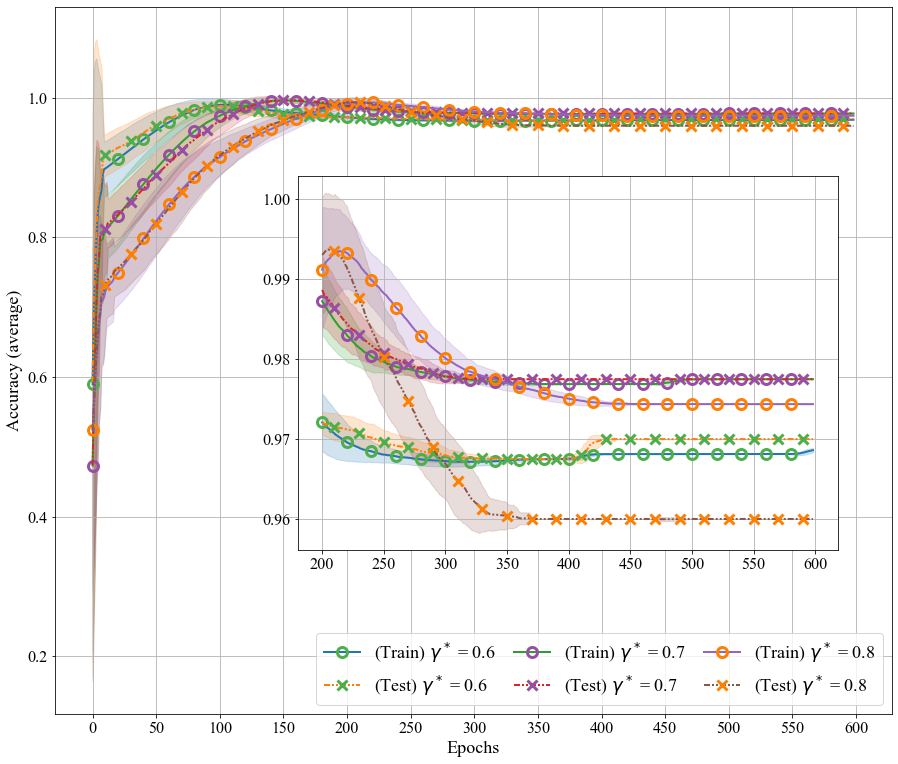

In [19]:
x_ticks_vec = np.arange(0,parameters["WNtS-WP_BC"]["gamma6"]["data"]["epochs"] + 1, 50)

fig, ax = plt.subplots(figsize = (15,13)) 

colors = pl.cm.tab10(np.linspace(0,1,10))
colors_markers = pl.cm.Set1(np.linspace(0,1,9))

L, alpha_for_all = None, 0.2
alphas = [6,7,8]

plt.setp(
    ax, xticks = x_ticks_vec,\
    xticklabels = x_ticks_vec
)



for i in range(6,9):
    A = parameters["WNtS-WP_BC"]["gamma" + str(i)]["accuracy_test"]
    Tr = parameters["WNtS-WP_BC"]["gamma" + str(i)]["accuracy_train"]
    
    average_train = np.mean(Tr, axis = 0)
    stdev_train = np.std(Tr, axis = 0)
    average_test = np.mean(A, axis = 0)
    stdev_test = np.std(A, axis = 0)

    ax.plot(
        np.arange(len(average_train))[L:],average_train[L:],\
        label = r"(Train) $\gamma^*$ = 0." + str(alphas[i - 6]),\
        marker = "o", markevery = 20, markeredgecolor = colors_markers[(i - 6) + 2],\
        markerfacecolor = None,\
        fillstyle = 'none', c = colors[2 * (i - 6)]
    )
    ax.fill_between(
        np.arange(len(average_train))[L:], (average_train - stdev_train)[L:],\
        (average_train + stdev_train)[L:],\
        alpha = alpha_for_all,\
        color = colors[2 * (i - 6)]
    )
    ax.plot(
        np.arange(len(average_test))[L:], average_test[L:],\
        label = r"(Test) $\gamma^*$ = 0." + str(alphas[i - 6]), linestyle = (0,(3,1,1,1,1,1)),\
        marker = "x", markevery =(10,20), markeredgecolor = colors_markers[(i - 6) + 2],\
        markerfacecolor = None,\
        fillstyle = 'none', c = colors[2 * (i - 6) + 1]
    )
    ax.fill_between(
        np.arange(len(average_test))[L:], (average_test - stdev_test)[L:],\
        (average_test + stdev_test)[L:],\
        alpha = alpha_for_all,\
        color = colors[2 * (i - 6) + 1]
    )

ax.set_ylabel('Accuracy (average)')
ax.grid(True)
ax.set_xlabel('Epochs') 


###########################
### Small subfigure

axins = plt.axes([0.35, 0.3, 0.5, 0.4])
L = 200 

for i in range(6,9):
    A = parameters["WNtS-WP_BC"]["gamma" + str(i)]["accuracy_test"]
    Tr = parameters["WNtS-WP_BC"]["gamma" + str(i)]["accuracy_train"]
    
    average_train = np.mean(Tr, axis = 0)
    stdev_train = np.std(Tr, axis = 0)
    average_test = np.mean(A, axis = 0)
    stdev_test = np.std(A, axis = 0)

    axins.plot(
        np.arange(len(average_train))[L:],average_train[L:],\
        label = r"(Train) $\gamma^*$ = 0." + str(alphas[i - 6]),\
        marker = "o", markevery =20, markeredgecolor = colors_markers[(i - 6) + 2],\
        markerfacecolor = None, fillstyle = 'none', c = colors[2 * (i - 6)]
    )
    axins.fill_between(
        np.arange(len(average_train))[L:], (average_train - stdev_train)[L:],\
        (average_train + stdev_train)[L:], alpha = alpha_for_all, color = colors[2 * (i - 6)]
    )
    axins.plot(
        np.arange(len(average_test))[L:], average_test[L:],\
        label = r"(Test) $\gamma^*$ = 0." + str(alphas[i - 6]), linestyle = (0,(3,1,1,1,1,1)),\
        marker = "x", markevery =(10,20), markeredgecolor = colors_markers[(i - 6) + 2],\
        markerfacecolor = None, fillstyle = 'none', c = colors[2 * (i - 6) + 1]
    )
    axins.fill_between(
        np.arange(len(average_test))[L:], (average_test - stdev_test)[L:],\
        (average_test + stdev_test)[L:],\
        alpha = alpha_for_all, color = colors[2 * (i - 6) + 1]
    )
    
axins.grid(True)
ax.legend(loc = 4, ncol = 3)
plt.show()

And tables are generated as before:

In [20]:
M = []
for alpha in [6,7,8]:
    data_now = parameters["WNtS-WP_BC"]["gamma" + str(alpha)].copy()
    av_test_now = np.mean(data_now["accuracy_test"])
    std_test_now = np.std(data_now["accuracy_test"])
    av_train_now = np.mean(data_now["accuracy_train"])
    std_train_now = np.std(data_now["accuracy_train"])
    
    M.append(
        (("0." + str(alpha)),(str(np.round(av_train_now,3))) +\
         " + " + str(np.round(std_train_now,3)),\
        (str(np.round(av_test_now,3)) + " + " + str(np.round(std_test_now,3)))
    ))   

f = pd.DataFrame(M, columns = [r"$\alpha$","training set", "test set"])
f.style.hide_index()

$\alpha$,training set,test set
0.6,0.965 + 0.043,0.967 + 0.042
0.7,0.964 + 0.058,0.963 + 0.059
0.8,0.947 + 0.076,0.939 + 0.073


<h1 align="left"> E) Case weights-k-sharing, with k varying </h1>


Another thing that is interesting doing is introduncing variations on this model, like the k-folding


Let'stransform the previous data into matrices

/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


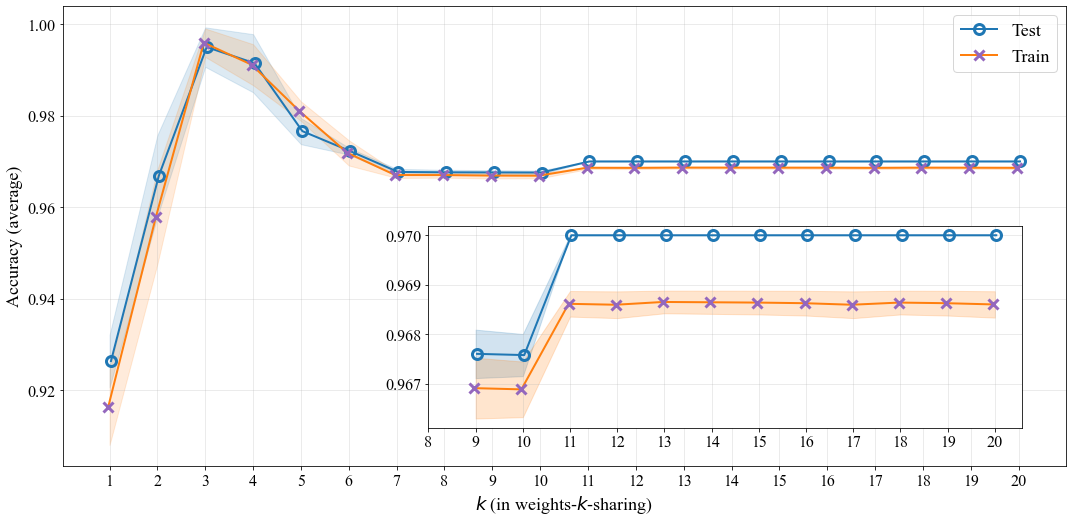

In [21]:
fig, ax = plt.subplots(figsize = (15,8)) 
colors = pl.cm.tab20(np.linspace(0,1,10))
colors_markers = pl.cm.tab20(np.linspace(0,1,10))

marker_type = {0 : "o", 1 : "x"}
label_type = {0 : "Test", 1 : "Train"}
Acc_test, Acc_train = parameters["WkS-WP_vary"]["Acc_test"], parameters["WkS-WP_vary"]["Acc_train"]

for A in zip((Acc_test, Acc_train),(0,1)): 
    average = np.mean(A[0], axis = 1)
    stdev = np.std(A[0], axis = 1)
    
    errorevery_case = 1 * (A[1] == 0)
    trans_now = Affine2D().translate(-.03 +.06*errorevery_case,0) +ax.transData

    ax.plot(
        np.arange(1,len(average) + 1),average, 
        marker = marker_type[A[1]],\
        transform = trans_now,\
        markeredgecolor = colors[4*A[1]],\
        markerfacecolor = None,\
        fillstyle = 'none',label = label_type[A[1]], color = colors[A[1]]
    )
    ax.fill_between(
        np.arange(1,len(average) + 1), average - stdev, average + stdev,\
        color = colors[A[1]], alpha = 0.15
    )

alpha_for_all = 0.2
ax.grid(alpha = .3)
ax.set_ylabel('Accuracy (average)')
ax.set_xlabel(r'$k$ (in weights-$k$-sharing)')
ax.set_xticks(np.arange(1,21))    
axins = plt.axes([0.4, 0.2, 0.55, 0.35])


L= 8#None
for A in zip((Acc_test, Acc_train),(0,1)):
    average = np.mean(A[0], axis = 1)
    stdev = np.std(A[0], axis = 1)
    errorevery_case = 1 * (A[1] == 0)
    trans_now = Affine2D().translate(-.03 +.06 * errorevery_case,0) + axins.transData

    axins.plot(
        np.arange(1,len(average) + 1)[L:],average[L:],transform = trans_now,\
        marker = marker_type[A[1]],\
        markeredgecolor = colors[4*A[1]],\
        markerfacecolor = None,\
        fillstyle = 'none', label = None, color = colors[A[1]]
    )
    axins.fill_between(
        np.arange(1,len(average) + 1)[L:], (average - stdev)[L:], (average + stdev)[L:],\
        color = colors[A[1]], alpha = alpha_for_all
    )

axins.grid(alpha = .3)
    
ax.legend(loc = 0)

axins.set_xticks(np.arange(L,21))    
plt.tight_layout( rect = [0, 0.03, 1, 0.95]) 
plt.show()

In [22]:
folder_now = "Statistics/Extras/"
with open(folder_now + 'parameters_Extras.p', 'rb') as fp: parameters_extras = pickle.load(fp)

In [23]:
parameters_now = parameters_extras["PSBC"]
psbc_avr_test, psbc_avr_train =  parameters_now['Avr_test'], parameters_now['Avr_train']
psbc_std_test, psbc_std_train =  parameters_now['Std_test'], parameters_now['Std_train']

In [24]:
parameters_now = parameters_extras["ANN"]
ann_avr_test, ann_avr_train =  parameters_now['Avr_test'], parameters_now['Avr_train']
ann_std_test, ann_std_train =  parameters_now['Std_test'], parameters_now['Std_train']

In [25]:
parameters_now = parameters_extras["KNN"]
knn_avr_test2, knn_avr_train2 =  parameters_now['Avr_test2'], parameters_now['Avr_train2']
knn_avr_test3, knn_avr_train3 =  parameters_now['Avr_test3'], parameters_now['Avr_train3']

### The 1D  box problem of type  $\gamma^* \leq X < \beta^*$

As suggested towards the end of the paper, the model has some limitations when one consider low dimensional models. That's because the type of layers we are using they enhance model compression. In this way, training a 1D toy problem with labels

$$ Y_{(i)} = \bf{1}_{\{[\gamma^*,\beta^*]\}}(X_{(i)})$$

for $0 < \gamma^* <\beta <1$ might be a challenge, because the model can only use 1 variable per layer. 

One way to oversome this issue is using feature engineering, where one could for instance redefine the input vector to

$$\widetilde{X}_{(i)}= \begin{bmatrix}
                            X_{(i)}\\
                            X_{(i)}
                        \end{bmatrix}$$

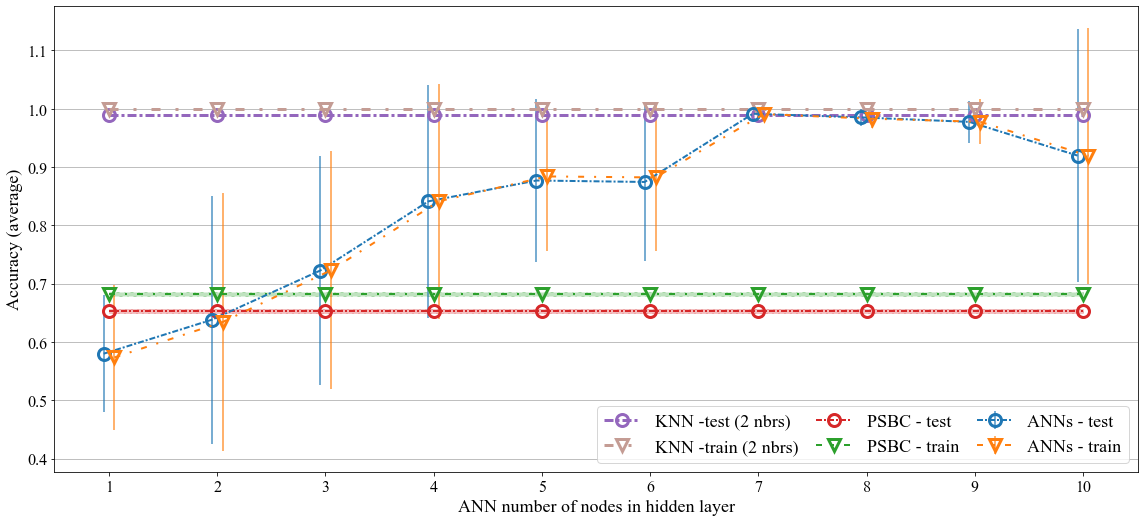

In [26]:
from  matplotlib.transforms import Affine2D

fig, ax  = plt.subplots(figsize=(16,8))


# Some plotting parameters
x = np.arange(1,11)
colors = pl.cm.tab20(np.linspace(0,1,10))
M, msize, e_width, alpha = 0, 12, 3, .6
ln_stl = (0,(3,1,1,1))
ln_stl_2 = (0,(3,5,1,5))

## knn 2
ax.plot(
    x, knn_avr_test2 * np.ones(len(x)), lw = 3, linestyle = ln_stl, label = "KNN -test (2 nbrs)",\
    color = colors[M + 4],marker = 'o',fillstyle = "none", markersize = msize,\
    markeredgewidth = e_width
)
ax.plot(
    x, knn_avr_train2 * np.ones(len(x)), lw = 3, linestyle = ln_stl_2, label = "KNN -train (2 nbrs)",\
    color = colors[M + 5],marker = 'v',fillstyle = "none", markersize = msize,\
    markeredgewidth = e_width
)

## PSBC
ax.plot(x, psbc_avr_test * np.ones(len(x)), lw = 2, marker = 'o',\
        markerfacecolor = None, color = colors[M + 3],\
       label = "PSBC - test", linestyle = ln_stl, markersize = msize, fillstyle = "none",\
        markeredgewidth = e_width
      )
ax.fill_between(
    x, (psbc_avr_test - psbc_std_test) * np.ones(len(x)),\
    (psbc_avr_test + psbc_std_test) * np.ones(len(x)),\
    alpha = alpha/2, color = colors[M + 3], linestyle = ln_stl
)
ax.plot(
    x, psbc_avr_train * np.ones(len(x)), lw = 2, marker = 'v',\
    markerfacecolor = None, color = colors[M + 2],\
    label = "PSBC - train", linestyle = ln_stl_2, fillstyle = "none", markersize = msize,\
    markeredgewidth = e_width
)
ax.fill_between(
    x, (psbc_avr_train - psbc_std_train) * np.ones(len(x)),\
    (psbc_avr_train + psbc_std_train) * np.ones(len(x)),\
    alpha =alpha/2, color = colors[M + 2],linestyle = ln_stl_2
)

## ANN 
trans_now = Affine2D().translate(-.05,0) + ax.transData
markers, caps, bars = ax.errorbar(
    x, np.asarray(ann_avr_test), yerr = ann_std_test,transform = trans_now,\
     label = "ANNs - test", color = colors[M], linestyle = ln_stl,\
    marker = "o",fillstyle = "none", markersize = msize,\
    markeredgewidth = e_width
)

[bar.set_alpha(alpha) for bar in bars]
[bar.set_linewidth(2) for bar in bars]
trans_now = Affine2D().translate(+.05,0) + ax.transData
markers, caps, bars = ax.errorbar(
    x, np.asarray(ann_avr_train), yerr = ann_std_train, transform = trans_now,\
     label = "ANNs - train", color = colors[M + 1], linestyle = ln_stl_2,\
     marker = "v", fillstyle = "none", markersize = msize,\
    markeredgewidth = e_width
)

[bar.set_alpha(alpha) for bar in bars]
[bar.set_linewidth(2) for bar in bars]

ax.set_xticks(x)
plt.ylabel("Accuracy (average)")
plt.xlabel("ANN number of nodes in hidden layer")

plt.tight_layout(rect = [0, 0.03, 1, 0.95]) 
plt.legend(ncol = 3, loc = 4)
plt.grid(True, axis = "y")
plt.show()    

In [27]:
import pandas as pd

Q = []

nodes = np.arange(1,11)
row = [(str(np.round(a[0],4))) + " + " + str(np.round(a[1],4)) for  a in np.c_[ann_avr_train, ann_std_train]]
column = ["ANN train: average +std"]
Q = row

row = [(str(np.round(a[0],4))) + " + " + str(np.round(a[1],4)) for  a in np.c_[ann_avr_test, ann_std_test]]
column.append("ANN test: average +std")
Q = np.c_[Q,row]

f = pd.DataFrame(np.squeeze(Q))
f.columns=column
f.index = nodes
f

,ANN train: average +std,ANN test: average +std
1,0.5736 + 0.124,0.58 + 0.1004
2,0.6343 + 0.2206,0.6382 + 0.2128
3,0.723 + 0.204,0.7225 + 0.196
4,0.8415 + 0.2013,0.8412 + 0.1994
5,0.884 + 0.1275,0.877 + 0.139
6,0.8822 + 0.1255,0.8745 + 0.1352
7,0.9909 + 0.0068,0.9915 + 0.0054
8,0.9829 + 0.0159,0.9853 + 0.0146
9,0.9777 + 0.0383,0.9775 + 0.0355
10,0.9195 + 0.2197,0.9198 + 0.2166


Data for the PSBC is  

In [28]:
print("\n PSBC ,  test:", np.round(psbc_avr_test,4) ,"+-", np.round(psbc_std_test,4))
print("\n PSBC ,  train:",  np.round(psbc_avr_train,4),"+-", np.round(psbc_std_train,4) )


 PSBC ,  test: 0.653 +- 0.0037

 PSBC ,  train: 0.6822 +- 0.0028


In [29]:
print("\n KNN - 2,  test:", np.round(knn_avr_test2,4) )
print("\n KNN - 2,  train:", np.round(knn_avr_train2,4) )

print("\n KNN - 3,  test:", np.round(knn_avr_test3,4) )
print("\n KNN - 3,  train:", np.round(knn_avr_train3,4) )


 KNN - 2,  test: 0.99

 KNN - 2,  train: 1.0

 KNN - 3,  test: 0.9944

 KNN - 3,  train: 0.9994
